# Exploratory Data Analysis (EDA) - Image Dataset

This notebook provides a detailed analysis of the image dataset located at `data/raw/Kaggle_Prepared/train/RGB`.

In [4]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set visual style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading and Label Extraction
We will load the file paths and extract labels from the filenames. The expected filename format is `Label_hyper_X.png`.

In [5]:
# Define dataset path
DATA_DIR = Path('../../data/raw/Kaggle_Prepared/train/RGB')

# Check if directory exists
if not DATA_DIR.exists():
    print(f"Directory {DATA_DIR} not found!")
else:
    print(f"Found data directory: {DATA_DIR}")

# Get all image files
image_extensions = ['*.png', '*.jpg', '*.jpeg']
image_paths = []
for ext in image_extensions:
    image_paths.extend(DATA_DIR.glob(ext))

print(f"Total images found: {len(image_paths)}")

Found data directory: ..\..\data\raw\Kaggle_Prepared\train\RGB
Total images found: 600


In [6]:
# Parse labels
data = []
for p in image_paths:
    filename = p.name
    # Assuming label is the first part before the first underscore
    # E.g., 'Health_hyper_1.png' -> 'Health'
    try:
        label = filename.split('_')[0]
    except IndexError:
        label = 'Unknown'
    
    data.append({
        'path': str(p),
        'filename': filename,
        'label': label
    })

df = pd.DataFrame(data)
df.head()

,path,filename,label
0,..\..\data\raw\Kaggle_Prepared\train\RGB\Healt...,Health_hyper_1.png,Health
1,..\..\data\raw\Kaggle_Prepared\train\RGB\Healt...,Health_hyper_10.png,Health
2,..\..\data\raw\Kaggle_Prepared\train\RGB\Healt...,Health_hyper_100.png,Health
3,..\..\data\raw\Kaggle_Prepared\train\RGB\Healt...,Health_hyper_101.png,Health
4,..\..\data\raw\Kaggle_Prepared\train\RGB\Healt...,Health_hyper_102.png,Health


## 2. Class Distribution Analysis
Let's see how many images we have for each class.

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15756\2161082873.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


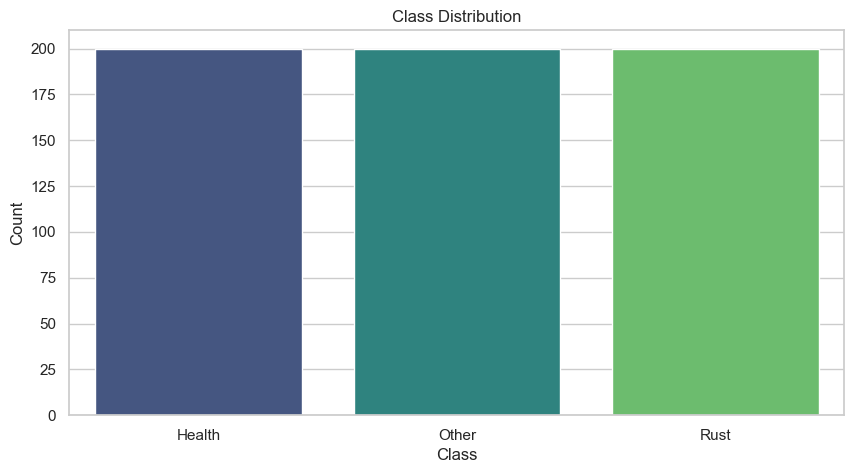

label
Health    200
Other     200
Rust      200
Name: count, dtype: int64


In [7]:
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

print(df['label'].value_counts())

## 3. Sample Image Visualization
Displaying random samples from each category to understand the data quality and features.

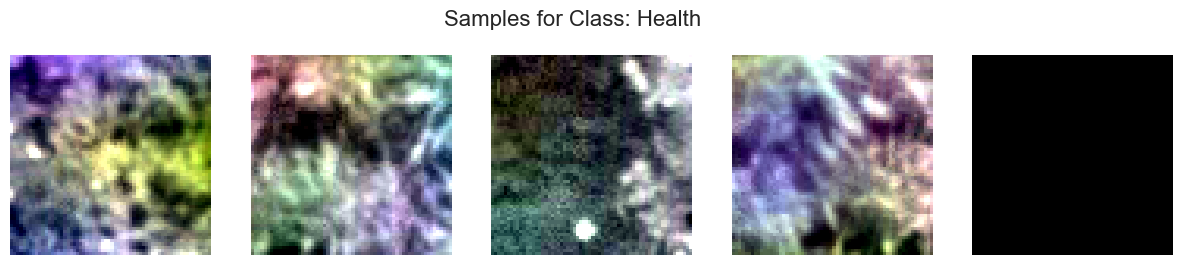

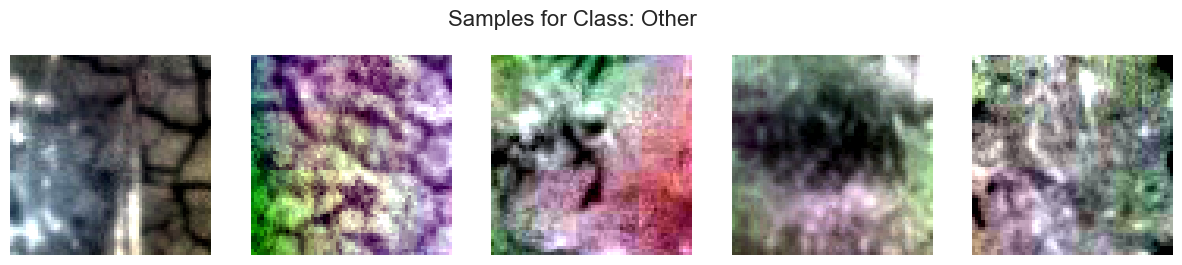

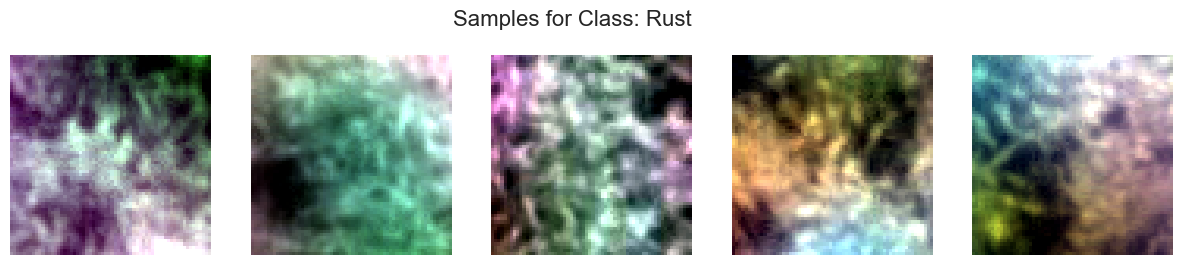

In [8]:
def plot_samples(df, n_samples=5):
    classes = df['label'].unique()
    for cls in classes:
        subset = df[df['label'] == cls].sample(n=min(n_samples, len(df[df['label'] == cls])), random_state=42)
        
        plt.figure(figsize=(15, 3))
        plt.suptitle(f'Samples for Class: {cls}', fontsize=16)
        
        for i, (_, row) in enumerate(subset.iterrows()):
            img = cv2.imread(row['path'])
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.subplot(1, n_samples, i + 1)
                plt.imshow(img)
                plt.axis('off')
            else:
                print(f"Could not read image: {row['path']}")
        plt.show()

plot_samples(df)

## 4. Image Properties Analysis
Analyzing image dimensions (Height, Width) and aspect ratios.

In [9]:
# Function to get image stats
def get_image_stats(row):
    try:
        img = cv2.imread(row['path'])
        if img is not None:
            h, w, c = img.shape
            return pd.Series([h, w, c])
        else:
            return pd.Series([np.nan, np.nan, np.nan])
    except Exception as e:
        return pd.Series([np.nan, np.nan, np.nan])

# Apply for a subset if data is too large, otherwise full dataset
# For now, we apply to full dataset assuming a reasonable size (< 10k images)
# If dataset is huge, sample it: df_sample = df.sample(1000)
df[['height', 'width', 'channels']] = df.apply(get_image_stats, axis=1)

# Drop rows where image reading failed
df.dropna(subset=['height', 'width'], inplace=True)

print("Image Dimensions Summary:")
print(df[['height', 'width']].describe())

Image Dimensions Summary:
       height  width
count   600.0  600.0
mean     64.0   64.0
std       0.0    0.0
min      64.0   64.0
25%      64.0   64.0
50%      64.0   64.0
75%      64.0   64.0
max      64.0   64.0


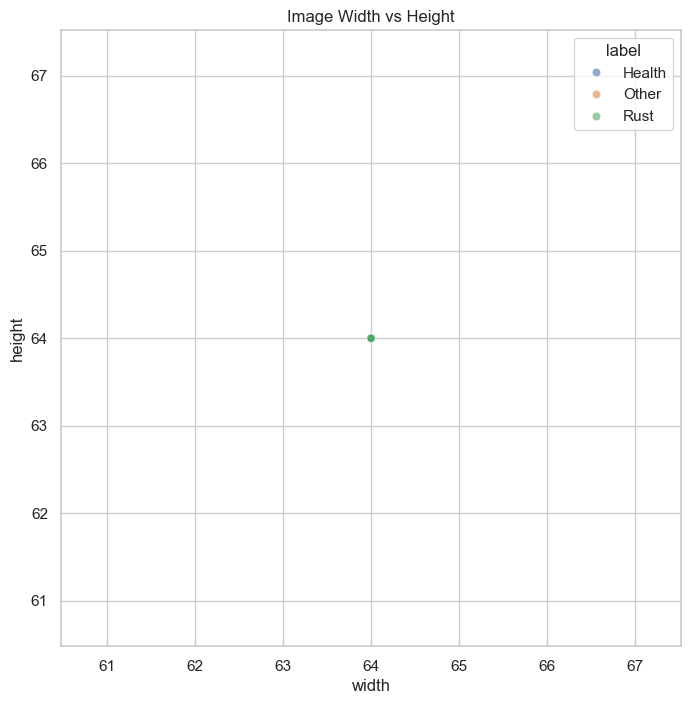

In [10]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x='width', y='height', hue='label', data=df, alpha=0.6)
plt.title('Image Width vs Height')
plt.show()

## 5. Pixel Intensity Analysis
Analyzing the average pixel intensity for each channel (R, G, B) across classes.

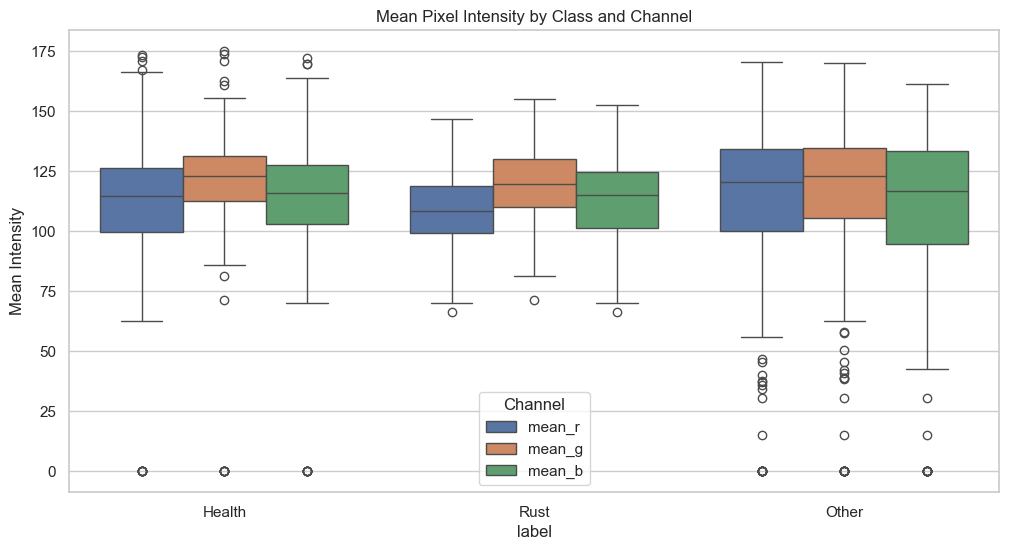

In [11]:
def get_mean_colors(row):
    img = cv2.imread(row['path'])
    if img is not None:
        # OpenCV is BGR
        mean_b = np.mean(img[:, :, 0])
        mean_g = np.mean(img[:, :, 1])
        mean_r = np.mean(img[:, :, 2])
        return pd.Series([mean_r, mean_g, mean_b])
    return pd.Series([np.nan, np.nan, np.nan])

# Calculating for a sample to save time if needed
sample_df = df.sample(min(500, len(df)), random_state=42)
sample_df[['mean_r', 'mean_g', 'mean_b']] = sample_df.apply(get_mean_colors, axis=1)

plt.figure(figsize=(12, 6))
melted = sample_df.melt(id_vars='label', value_vars=['mean_r', 'mean_g', 'mean_b'], var_name='Channel', value_name='Mean Intensity')
sns.boxplot(x='label', y='Mean Intensity', hue='Channel', data=melted)
plt.title('Mean Pixel Intensity by Class and Channel')
plt.show()